In [ ]:
!pip install tensorflow-datasets


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [ ]:
train_ds, val_ds, test_ds= tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)



Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteUMRQ4Q/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print(train_ds)
class_names = np.array(['parasitized', 'uninfected'])
for image, label in train_ds.take(2):
  print(tf.squeeze(image).numpy())
  print(label.numpy())

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
1
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
1


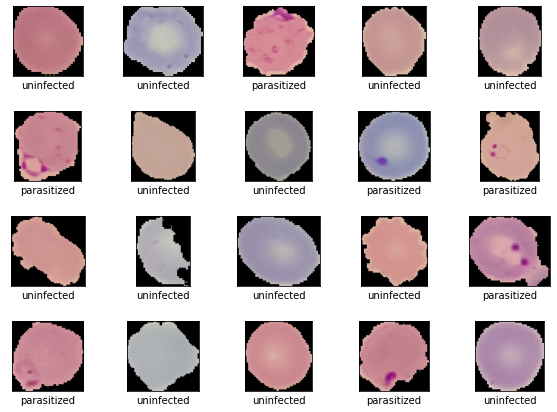

In [ ]:
i = 0
plt.figure(figsize = (10, 9))
for image, label in train_ds.take(20):
  #image = image.numpy().reshape(28,28)
  plt.subplot(5, 5, i+1)
  plt.subplots_adjust(hspace = 0.5)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image)
  plt.xlabel(class_names[label])
  i += 1
plt.show()


So our data is split into two classes, labelled as 0 and 1. Or parasited and uninfected.
Let's now plit our data so that we have 70% for training, 20% for validation and 10% for testing!

In [ ]:
for image, label in train_ds.take(10):
  print(image.shape)

train_num = len(train_ds)
valid_num = len(val_ds)
print(train_num)
print(valid_num)

(145, 148, 3)
(133, 127, 3)
(124, 121, 3)
(118, 118, 3)
(151, 148, 3)
(151, 130, 3)
(139, 175, 3)
(160, 148, 3)
(151, 139, 3)
(133, 136, 3)
19291
4133


In [ ]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

padded_train_ds = (train_ds.cache().map(pad).batch(32).prefetch(1))
padded_valid_ds = (val_ds.cache().map(pad).batch(32).prefetch(1))
padded_test_ds = (test_ds.cache().map(pad).batch(32).prefetch(1))



padded_train_length = len(padded_train_ds)
padded_valid_length = len(padded_valid_ds)
padded_test_length  = len(padded_test_ds)
print(padded_train_length)
print(padded_valid_length)
print(padded_test_length)

603
130
130


As we can see, images all have different sizes. We can use the ImagaDataGenerator anf flow_from_directory to change the size of the images and rescale them. While we are at it, how about we do a bit of image augmentation!!

In [ ]:
#image = image[:, :, 0]
print(image)

Cool, now let's build our Convolutional model and let's add our image augmentation to it!

In [ ]:
  model = tf.keras.models.Sequential([
    tf.keras.Input(shape = (200, 200, 3)),                                 
    #data_augmentation,
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()
history = model.fit(padded_train_ds, steps_per_epoch = padded_train_length, epochs = 15, validation_data = padded_valid_ds, validation_steps = padded_valid_length)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        1

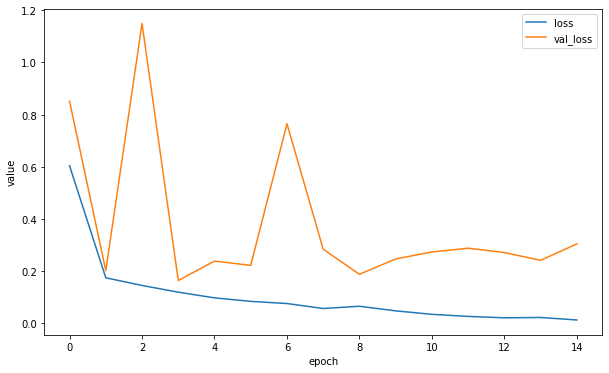

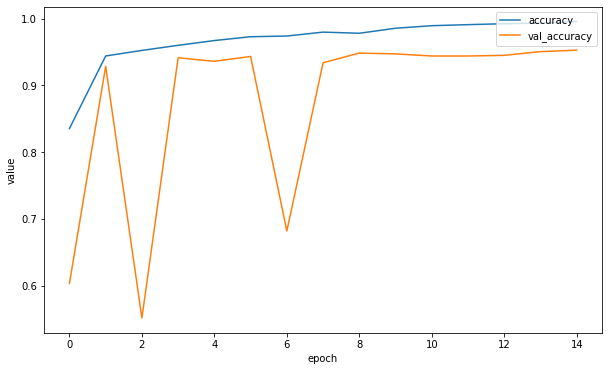

In [ ]:
epoch_range = range(15)
def plot_series(epoch_range, string):
  plt.plot(epoch_range, history.history[string], label = string)
  plt.plot(epoch_range, history.history['val_' + string], label = 'val_' + string)
  plt.legend(loc = 'upper right')
  plt.xlabel('epoch')
  plt.ylabel('value')
  plt.grid(False)
  plt.show()

plt.figure(figsize = (10, 6))
plot_series(epoch_range, 'loss')

plt.figure(figsize = (10, 6))
plot_series(epoch_range, 'accuracy')

Let's now use the model to predict if the images from our test dataset fall into the unifected or the parasitized categories.

In [ ]:
model.evaluate(padded_test_ds)

32/32 [==============================] - 5s 141ms/step - loss: 0.3950 - accuracy: 0.9499


[0.39502596855163574, 0.9499274492263794]

Let's now build the same model, apart for the output layer, where we removed the activation function and output two values instead of one. The goal here is to plot the predictions.

In [ ]:
  model = tf.keras.models.Sequential([
    tf.keras.Input(shape = (200, 200, 3)),                                 
    #data_augmentation,
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(2)
])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()
history = model.fit(padded_train_ds, steps_per_epoch = padded_train_length, epochs = 5, validation_data = padded_valid_ds, validation_steps = padded_valid_length)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)       

603/603 [==============================] - 23s 38ms/step - loss: 0.6698 - accuracy: 0.8269 - val_loss: 0.9036 - val_accuracy: 0.7576
Epoch 2/5
603/603 [==============================] - 23s 37ms/step - loss: 0.1902 - accuracy: 0.9384 - val_loss: 0.2120 - val_accuracy: 0.9323
Epoch 3/5
603/603 [==============================] - 23s 38ms/step - loss: 0.1395 - accuracy: 0.9548 - val_loss: 0.2124 - val_accuracy: 0.9330
Epoch 4/5
603/603 [==============================] - 22s 37ms/step - loss: 0.1135 - accuracy: 0.9616 - val_loss: 0.2119 - val_accuracy: 0.9260
Epoch 5/5
603/603 [==============================] - 23s 37ms/step - loss: 0.0923 - accuracy: 0.9690 - val_loss: 0.2029 - val_accuracy: 0.9453


In [ ]:
model.evaluate(padded_test_ds)

130/130 [==============================] - 5s 38ms/step - loss: 0.2492 - accuracy: 0.9429


[0.24917817115783691, 0.9429124593734741]

In [ ]:
image_batch, label_batch = next(iter(padded_test_ds))
image_batch = image_test
label_batch = labels_test

predicted_batch = model.predict(image_batch)
#print(predicted_batch)


predicted_ids = np.argmax(predicted_batch, axis = 1)
predicted_class_names = class_names[predicted_ids]

print('True labels:      ', label_batch)
print('Predicted labels: ', predicted_ids)

True labels:       [1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]
Predicted labels:  [1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0]


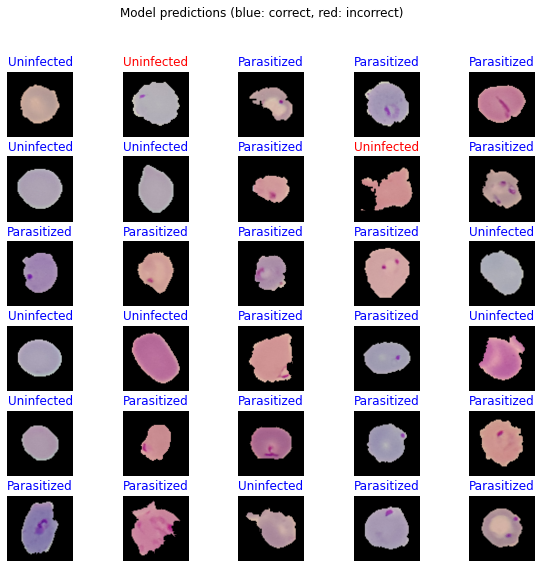

In [ ]:
plt.figure(figsize = (10, 9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color = color)
  plt.axis('off')
  plt.suptitle('Model predictions (blue: correct, red: incorrect)')